In [15]:
import pickle

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [17]:
# !ls zed

import glob
image_files = glob.glob('./zed/whitelines/*left.jpg')

images = []
for fname in image_files:
    img = cv2.imread(fname)
    images.append(img)
    
print(len(images))

image = images[0]
image.shape

# image = plt.imread("./zed/zed2.png")
# print image.shape
# plt.imshow(image)

4


(376, 672, 3)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.57 ms


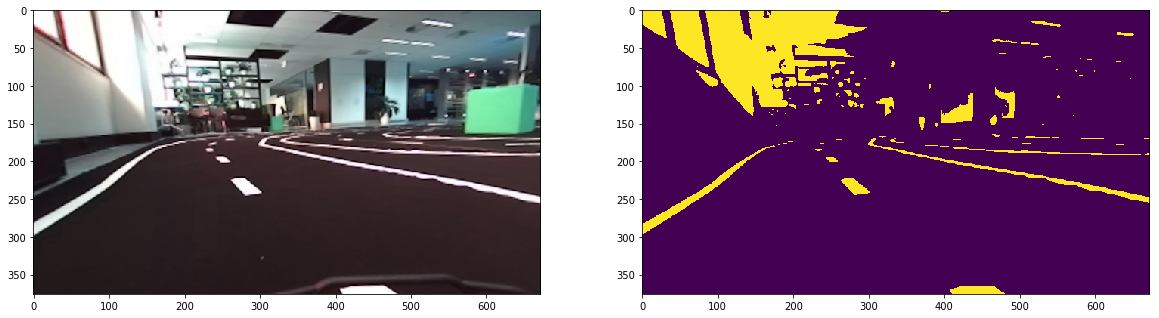

In [54]:


def abs_sobel_thresh(hls, orient='x', sobel_kernel=3, thresh=(0, 255)):

    # Convert to HLS and use lightness as the gray
    L = hls[:,:,1]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(L, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(L, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary
    return binary_output

def hsl_channel_threshold(hls, l_thresh=(0.,.5)):
    l_channel = hls[:,:,1]

    # Threshold lightness channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

    return l_binary

def colour_threshold(image, thresh=(210, 255)):
    combined = np.zeros_like(image[:,:,0])
    combined[(image[:,:,0] > thresh[0]) & (image[:,:,1] > thresh[0]) & (image[:,:,2] > thresh[0])
            & (image[:,:,0] < thresh[1]) & (image[:,:,1] < thresh[1]) & (image[:,:,2] < thresh[1])] = 255
    return combined

def filter_lanes(image):
    x_grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 80))
    y_grad_binary = abs_sobel_thresh(image, orient='y', thresh=(20, 80))
    hsl_channel_binary = hsl_channel_threshold(image, l_thresh=(200., 255))

    combined = np.zeros_like(x_grad_binary) #this makes it 1 channel
#     combined[(x_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1) & (x_grad_binary == 1)] = 1
#     combined[(y_grad_binary == 1) | (x_grad_binary == 1)] = 1
#     combined[(mag_binary == 1)] = 1
#     combined[(dir_binary == 1)] = 1
    combined[(hsl_channel_binary == 1)] = 1
#     combined[(hsl_channel_binary == 1) & (x_grad_binary == 1) & (y_grad_binary == 1)] = 1   
#     combined[(hsl_channel_binary == 1) & (x_grad_binary == 1) & (y_grad_binary == 1) & (dir_binary == 1)] = 1   
#     combined[((y_grad_binary == 1) | (x_grad_binary == 1)) & (hsl_channel_binary == 1)] = 1
#     combined[(dir_binary == 1) & (hsl_channel_binary == 1)] = 1

    return combined


def plot_images(image1, image2):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.imshow(image1)
    plt.subplot(1, 2, 2)
    plt.imshow(image2)
    
image = images[2]
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS).astype(np.float)
# image = image[:, :, [2, 1, 0]]
# plt.imshow(image)

# print(hls)
# %time modified = colour_threshold(image)
%time modified = filter_lanes(hls)
plot_images(image, modified)

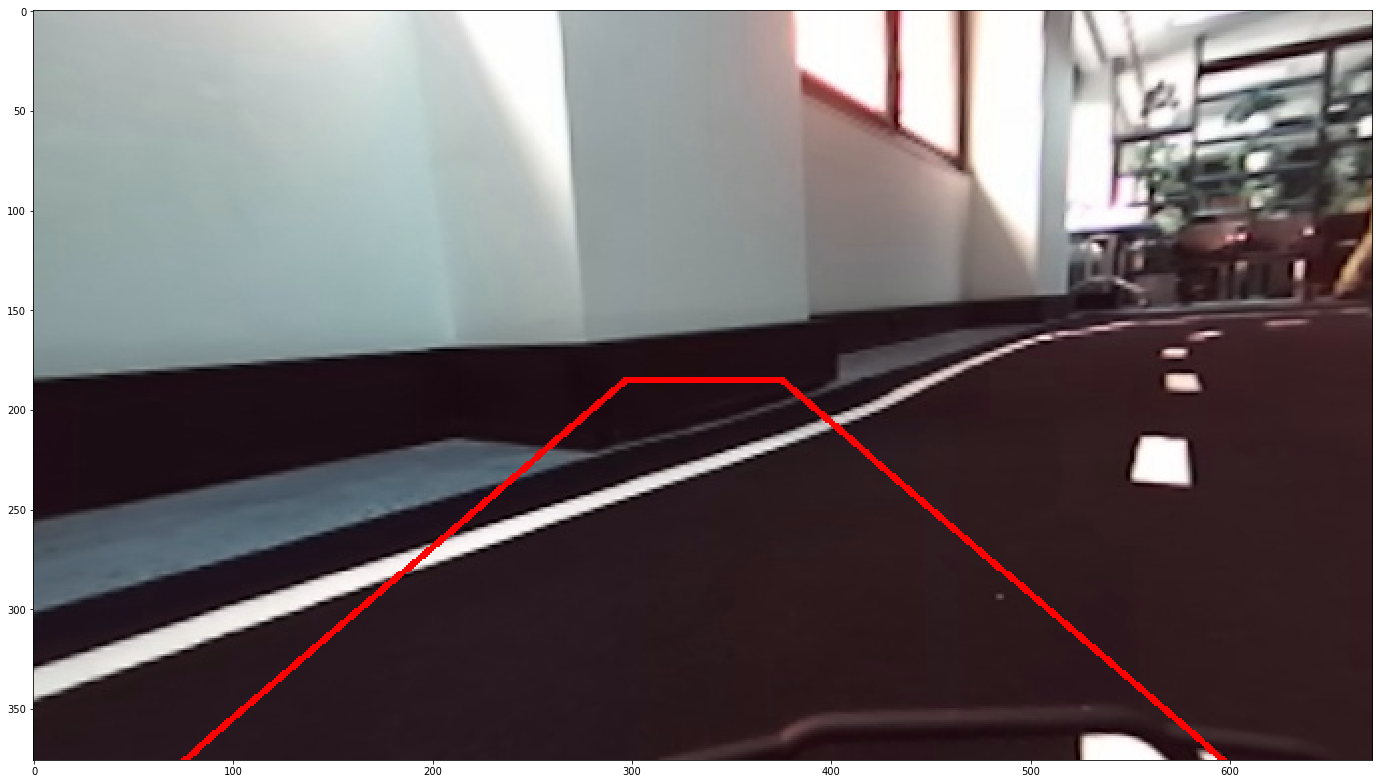

In [20]:
#left
left_image = np.copy(images[1])
# left_image = left_image[250:, :]
def show_warp_lines_left(image):
    color=[255, 0, 0]
    warp_vertices_src = [(75, image.shape[0]), (297, 185), (375, 185), (597, image.shape[0])]
    cv2.line(image, warp_vertices_src[0], warp_vertices_src[1], color, 2)
    cv2.line(image, warp_vertices_src[2], warp_vertices_src[3], color, 2)
    cv2.line(image, warp_vertices_src[1], warp_vertices_src[2], color, 2)
    return image

left_image = show_warp_lines_left(left_image)

f, ax = plt.subplots(1, 1, figsize=(24,24))
ax.imshow(left_image)

In [3]:
def warp_image(image, mode='normal'):
    image = np.copy(image)
    warp_vertices_src = [(75, image.shape[0]), (300, 185), (385, 185), (597, image.shape[0])] #both sides
    src = np.float32(warp_vertices_src)
    dst = np.float32([[375, image.shape[0]], [375, 0], [697, 0], [697, image.shape[0]]])

#     color=[255, 0, 0]
#     cv2.line(image, warp_vertices_src[0], warp_vertices_src[1], color, 1)
#     cv2.line(image, warp_vertices_src[2], warp_vertices_src[3], color, 1)
#     cv2.line(image, warp_vertices_src[1], warp_vertices_src[2], color, 1)
        
    if mode=='normal':
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(image, M, (1072, image.shape[0]), flags=cv2.INTER_LINEAR)
    elif mode=='inverse':
        M = cv2.getPerspectiveTransform(dst, src)
        warped = cv2.warpPerspective(image, M, (672, image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

image = images[0]
print(image.shape)
warped = warp_image(image)
warped_inverse = warp_image(warped, mode='inverse')
f, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(image)
ax[0].set_title('original')
ax[1].imshow(warped_inverse)
ax[1].set_title('reverted after warp')
plt.figure(figsize=(16,8))
plt.title('warped')
plt.imshow(warped)

NameError: name 'images' is not defined

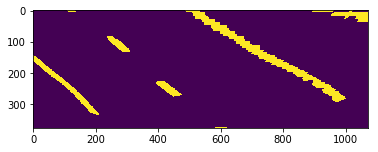

In [66]:
left_image = images[2]
left_filtered = filter_lanes(left_image)
left_warped = warp_image(left_filtered)

plt.imshow(left_warped)

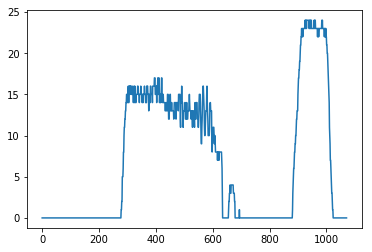

In [26]:
image = images[1]
filtered = filter_lanes(image)
warped = warp_image(filtered)

histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

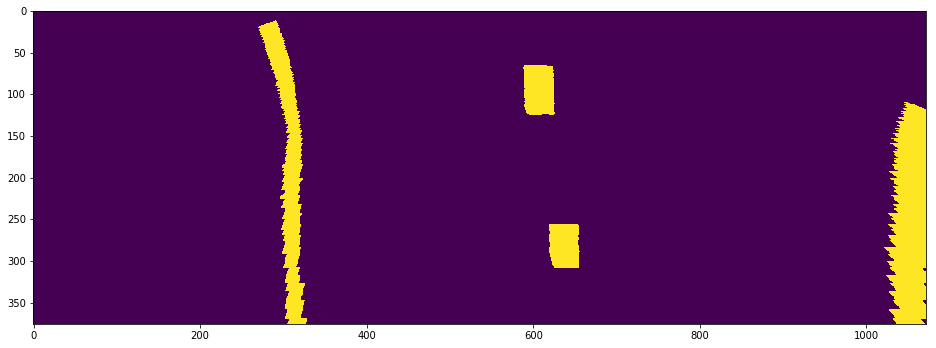

In [39]:

def clean_image(image):
    labels = label(image)  # labels[0] = image with labels, labels[1] = count of labels
    result = labels[0]
    
    for object_no in range(1, labels[1]+1):
        # Find pixels with each label value
        nonzero = (result == object_no).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if ((np.max(nonzeroy)-np.min(nonzeroy)<5) & (np.max(nonzerox)-np.min(nonzerox)<5)):
            result[(result == object_no)] = 0
    result[result>0] = 1
    return result

left_clean = clean_image(left_warped)
left_clean = cv2.flip(left_clean, 0)
plt.figure(figsize=(16,8))
plt.imshow(left_clean)

# right_clean = clean_image(right_warped)
# right_clean = cv2.flip(right_clean, 0)
# plt.figure(figsize=(16,8))
# plt.imshow(right_clean)


In [27]:
def get_line_fit(points, y_axis):
    y, x = np.nonzero(points)
    fit = np.polyfit(y, x, 2)
    line_fitx = fit[0]*y_axis**2 + fit[1]*y_axis + fit[2]
    return line_fitx

image_height = left_clean.shape[0]
y_axis = np.linspace(-50, image_height-1, num=image_height+50)
y, x = np.nonzero(left_clean)
left_fitx = get_line_fit(left_clean, y_axis)

# plt.plot(x, y, color='yellow')
# plt.plot(left_fitx, y_axis, color='blue')
# plt.xlim(0, left_warped.shape[1])
# plt.ylim(-50, image_height)


# y, x = np.nonzero(right_clean)
# right_fitx = get_line_fit(right_clean, y_axis)

# plt.plot(x, y, color='yellow')
# plt.plot(right_fitx, y_axis, color='red')


# print(centre[50], y_axis[50])
# centre = (left_fitx + right_fitx)/2
# plt.plot(centre, y_axis, color='green')


# plt.gca().invert_yaxis() # to visualize as we do the images

NameError: name 'left_clean' is not defined

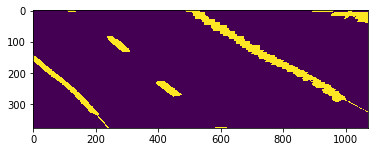

In [65]:
from scipy.ndimage.measurements import label

# returns lines, debug image
def find_all_lines(image):
    labeled_array, num_features = label(image)
#     print(num_features)
#     print(labeled_array.shape)
    
    image_height = image.shape[0]
    y_axis = np.linspace(0, image_height-1, num=image_height)
    
    debug_image = np.zeros_like(image)
    debug_image[labeled_array > 0] = 255
    
    lines = []
    
    def get_line_fit(points, y_axis):
        y, x = np.nonzero(points)
        # ignore small blocks
        if ((np.max(y)-np.min(y)<40) & (np.max(x)-np.min(x)<40)):
            return None
            
        fit = np.polyfit(y, x, 2)
        line_fitx = fit[0]*y_axis**2 + fit[1]*y_axis + fit[2]
        return line_fitx

    for feature in range(1, num_features+1):
        feature_image = (labeled_array == feature)
        try:
            line_fit = get_line_fit(feature_image, y_axis)
            if line_fit is not None:
                lines.append(line_fit)
                points = np.vstack((line_fit, y_axis)).T.astype(np.int32)
                cv2.polylines(debug_image, [points], False, (255,0,0), 2)
        except:
            print("Unexpected error:", sys.exc_info()[0])

        
    return lines, debug_image

image = images[2]
filtered = filter_lanes(image)
left_warped = warp_image(filtered)
left_flip = cv2.flip(left_warped, 0)
lines, debug_image = find_all_lines(left_flip)
# print(lines)
plt.imshow(cv2.flip(debug_image, 0))


In [135]:
# centre point
middle_of_car = (200 + 460)

print(left_fitx[50], right_fitx[50])
print((left_fitx[50] + right_fitx[50])/2)
print(middle_of_car)

plt.plot(y_axis, (left_fitx-middle_of_car)*-1, color='blue')
plt.plot(y_axis, (right_fitx-middle_of_car)*-1, color='red')
plt.plot(y_axis, centre-middle_of_car, color='green')
plt.ylim(-472, 472)
plt.xlim(-50, 376)

(376,)


NameError: name 'right_fitx' is not defined

In [1]:
import sys
sys.path.append("../ros/src/computer_vision/src/")
from lane_detector import LaneDetector

import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(title, image1, image2=None):
    plt.figure(figsize=(20,20))
    plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(image1)
    if image2 is not None:
        plt.subplot(1, 2, 2)
        plt.title(title)
        plt.imshow(image2)

image_files = glob.glob('./zed/whitelines/*left.jpg')
image_files.sort()
left_images = []
for fname in image_files:
    img = cv2.imread(fname)
    left_images.append(img)

image_files = glob.glob('./zed/whitelines/*right.jpg')
image_files.sort()
right_images = []
for fname in image_files:
    img = cv2.imread(fname)
    right_images.append(img)
    
print(len(left_images), len(right_images))
print(left_images[0].shape)


(4, 4)
(376, 672, 3)


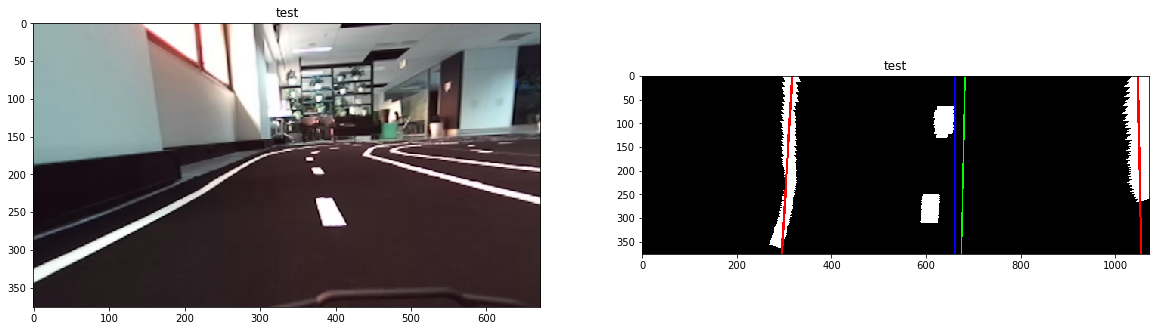

In [5]:
index = 3

detector = LaneDetector()

lines, debug_image = detector.process_images(left_images[index])

plot_images("test", left_images[index], debug_image)
# left_y, right_y, x_axis = detector.get_lanes()



In [ ]:
# import the necessary packages
import numpy as np
#import imutils
import cv2

class Stitcher:
    def __init__(self):
        # determine if we are using OpenCV v3.X
#         self.isv3 = imutils.is_cv3()
        pass

    def stitch(self, images, ratio=0.75, reprojThresh=4.0,
        showMatches=False):
        # unpack the images, then detect keypoints and extract
        # local invariant descriptors from them
        (imageB, imageA) = images
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # match features between the two images
        M = self.matchKeypoints(kpsA, kpsB,
            featuresA, featuresB, ratio, reprojThresh)

        # if the match is None, then there aren't enough matched
        # keypoints to create a panorama
        if M is None:
            return None

        # otherwise, apply a perspective warp to stitch the images
        # together
        (matches, H, status) = M
        result = cv2.warpPerspective(imageA, H,
            (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
        result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # check to see if the keypoint matches should be visualized
        if showMatches:
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches,
                status)

            # return a tuple of the stitched image and the
            # visualization
            return (result, vis)

        # return the stitched image
        return result

    def detectAndDescribe(self, image):
        # convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#         # check to see if we are using OpenCV 3.X
#         if self.isv3:
#             # detect and extract features from the image
        descriptor = cv2.xfeatures2d.SIFT_create()
        (kps, features) = descriptor.detectAndCompute(image, None)

#         # otherwise, we are using OpenCV 2.4.X
#         else:
            # detect keypoints in the image
#             detector = cv2.FeatureDetector_create("SIFT")
#             kps = detector.detect(gray)

#             # extract features from the image
#             extractor = cv2.DescriptorExtractor_create("SIFT")
#             (kps, features) = extractor.compute(gray, kps)

        # convert the keypoints from KeyPoint objects to NumPy
        # arrays
        kps = np.float32([kp.pt for kp in kps])

        # return a tuple of keypoints and features
        return (kps, features)

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB,
        ratio, reprojThresh):
        # compute the raw matches and initialize the list of actual
        # matches
        matcher = cv2.DescriptorMatcher_create("BruteForce")
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)
        matches = []

        # loop over the raw matches
        for m in rawMatches:
            # ensure the distance is within a certain ratio of each
            # other (i.e. Lowe's ratio test)
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # computing a homography requires at least 4 matches
        if len(matches) > 4:
            # construct the two sets of points
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # compute the homography between the two sets of points
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
                reprojThresh)

            # return the matches along with the homograpy matrix
            # and status of each matched point
            return (matches, H, status)

        # otherwise, no homograpy could be computed
        return None

    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # initialize the output visualization image
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # loop over the matches
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # only process the match if the keypoint was successfully
            # matched
            if s == 1:
                # draw the match
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return the visualization
        return vis

In [ ]:

index = 1
imageA = left_images[index]
imageB = right_images[index]
print(imageA.shape)
# stitch the images together to create a panorama
stitcher = Stitcher()
%time (result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

# show the images
plot_images("original", imageA, imageB)
plot_images("final", vis, result)
print(result.shape)
print(vis.shape)

plt.imshow(result[:, :680])